In [1]:
# Final Project
# Author Jose Aponte
# Professor John Droescher
# Quantitative Finance - ECO 41552

In [2]:
import datetime as dt
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import scipy.stats
import random
pd.options

In [63]:
tickers = pd.read_excel('sp500ComponentStocks.xlsx')
tickers.dropna(inplace=True)
tickers = tickers['Component'].tolist()
tickers

data = yf.download(tickers,period='10y')
display(data)


[*********************100%***********************]  501 of 501 completed


Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2013-03-25   26.943926  15.649508   75.029900   14.299473   26.177105   
2013-03-26   27.395941  15.564667   76.026810   14.224211   26.769621   
2013-03-27   27.572815  15.696644   76.064102   13.944750   26.729683   
2013-03-28   27.572815  15.998322   77.005119   13.654181   27.149092   
2013-04-01   26.889572  15.715503   76.716316   13.230055   27.375443   
...                ...        ...         ...         ...         ...   
2023-03-17  133.179993  13.980000  119.400002  155.000000  154.220001   
2023-03-20  134.539993  13.960000  118.680000  157.399994  156.119995   
2023-03-21  137.009995  14.370000  119.790001  159.279999  156.770004   
2023-03-22  133.729996  13.820000  113.599998  157.830002  153.669998   
2023-03-23  131.130005  13.630000  111.139999  158.929993  155.300003   

                                                                      ...  \
                   ABC        ABT       ACGL         ACN        ADBE  ...   
Date                                                                  ...   
2013-03-25   43.322212  27.958801  17.256666   60.898941   42.490002  ...   
2013-03-26   43.433556  28.413757  17.193333   61.836330   42.750000  ...   
2013-03-27   43.424976  28.628815  17.236668   62.118393   42.660000  ...   
2013-03-28   44.058666  29.216127  17.523333   63.022640   43.520000  ...   
2013-04-01   44.221378  29.207855  17.523333   62.923069   43.380001  ...   
...                ...        ...        ...         ...         ...  ...   
2023-03-17  152.020004  97.010002  63.150002  250.000000  358.140015  ...   
2023-03-20  153.860001  97.870003  65.610001  252.550003  362.880005  ...   
2023-03-21  156.039993  98.330002  67.209999  257.619995  374.220001  ...   
2023-03-22  153.440002  96.860001  65.870003  253.270004  361.709991  ...   
2023-03-23  150.929993  97.040001  65.599998  271.660004  369.000000  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2013-03-25  2148700  2211900  12900800   351800   865100  5041680   619236   
2013-03-26  1087400  2756500  12329600   633500  1082400  4114578  1211692   
2013-03-27   800500  4431400  12350800   598800  1269700  2687829  1355171   
2013-03-28   880200  4727000  17485200   668100  1392700  4555803  1722572   
2013-04-01   970300  1677200   9414200   579700   661400  2207517   714511   
...             ...      ...       ...      ...      ...      ...      ...   
2023-03-17  2175000  7941100  43187100  3143600  3467700  1798400  1397100   
2023-03-20  1464400  2906300  32042100  2062500  2222400  1190900   889300   
2023-03-21  1640900  3796100  31592300  2078500  1828800  1101300   993100   
2023-03-22  2148200  3446200  14952700  1932300  1750600  1059800   959000   
2023-03-23  2185000  3184600  14376000  1616600  1227500  1223300  1157800   

                                       
              ZBRA      ZION      ZTS  
Date                                   
2013-03-25  120600   1485100  1324600  
2013-03-26  111500   2136500  1396500  
2013-03-27  100800   1760000  1896800  
2013-03-28  118800   1322800  7434900  
2013-04-01  168100   1339500  1466300  
...            ...       ...      ...  
2023-03-17  461500  11211900  3605100  
2023-03-20  232300   7680700  2145800  
2023-03-21  160500   9474400  2453500  
2023-03-22  362700   7014400  1475600  
2023-03-23  244700   9694400  3560800  

[2518 rows x 3006 columns]

In [64]:
class Tool:
    def __init__(self,data, Tickers):
        self.price=data["Adj Close"]
        self.returns= self.price.pct_change()
        self.volume = data["Volume"]
        self.component = Tickers
        self.mtbl = pd.DataFrame(index=self.component)

    def bFactors(self):
        self.rMin = self.price.rolling(252).min()
        self.mtbl["Percent Above 252 day low"] = ((self.price - self.rMin)/self.rMin)[-20:].mean()
        self.mtbl["4/52 Price Osc"] = ((self.price.rolling(20).mean()-self.price.rolling(260).mean())
                                       /self.price.rolling(260).std())[-20:].mean()
        self.mtbl["39 Week Return"] = self.price.pct_change(189)[-20:].mean()
        self.mtbl["Price Volume"] = ((self.returns * self.volume).rolling(252).sum()[-20:].mean())
        self.mtbl["52 Week Trend"] = self.price.rolling(252).sum()[-20:].mean()
        return self.mtbl
    
    def agZS(self):
        self.mtbl = self.bFactors()
        self.scored = ((self.mtbl-self.mtbl.mean())/self.mtbl.std()).sum(axis=1)
        return self.scored
    
    def baskets(self):
        self.z_scored = self.agZS()
        return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index

returnsAdjClose = data['Adj Close'].pct_change().resample("M").sum().shift(-1)
       

In [65]:
timeFrame = pd.DataFrame(pd.date_range("2018-03-23", dt.datetime.today(),freq="M"))
timeFrame.rename(columns={0: "date"}, inplace=True)
lR, sR = pd.DataFrame(), pd.DataFrame()

for iterator in timeFrame.date:
    MF = Tool(data[data.index<=iterator], tickers)
    long, short = MF.baskets()
    lR = lR.append(returnsAdjClose[long].loc[iterator])
    sR = sR.append(returnsAdjClose[short].loc[iterator])

lR.iloc[-1].dropna()


/var/folders/bt/ptmzqj1n5c758pknt8gdj1f00000gn/T/ipykernel_10823/363720698.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lR = lR.append(returnsAdjClose[long].loc[iterator])
/var/folders/bt/ptmzqj1n5c758pknt8gdj1f00000gn/T/ipykernel_10823/363720698.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sR = sR.append(returnsAdjClose[short].loc[iterator])
/var/folders/bt/ptmzqj1n5c758pknt8gdj1f00000gn/T/ipykernel_10823/363720698.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lR = lR.append(returnsAdjClose[long].loc[iterator])
/var/folders/bt/ptmzqj1n5c758pknt8gdj1f00000gn/T/ipykernel_10823/363720698.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

NVR     0.035523
BKNG    0.008031
FSLR    0.232955
AZO    -0.073468
FICO    0.009123
OXY     0.005853
STLD   -0.143746
LVS    -0.045331
URI    -0.193282
WYNN   -0.016948
Name: 2023-02-28 00:00:00, dtype: float64

In [66]:
allTable = pd.DataFrame(lR.mean(axis=1) - sR.mean(axis=1)).shift()
allTable = allTable[-60:]
allTable['Return(Cumulative)'] = np.exp(np.log1p(allTable).cumsum())
allTable['Bench'] = yf.download('SPY', period = '5y')['Adj Close'].pct_change().resample('M').sum()
allTable['SPY(Cumulative)'] = np.exp(np.log1p(allTable['Bench']).cumsum())
allTable['Positive?'] = allTable[0] >0
allTable['Cumulative V SPY'] = allTable['Return(Cumulative)']-allTable['SPY(Cumulative)']
allTable['Cumulative V SPY Positive?'] = allTable['Cumulative V SPY'] > 0

allTable.index = allTable.index.date
allTable = allTable.round(3)
allTable

[*********************100%***********************]  1 of 1 completed


,0,Return(Cumulative),Bench,SPY(Cumulative),Positive?,Cumulative V SPY,Cumulative V SPY Positive?
2018-03-31,NaN,NaN,-0.007,0.993,False,NaN,False
2018-04-30,0.007,1.007,0.006,0.999,True,0.008,True
2018-05-31,0.029,1.037,0.024,1.024,True,0.014,True
2018-06-30,-0.021,1.015,0.006,1.030,False,-0.015,False
2018-07-31,-0.056,0.958,0.037,1.067,False,-0.109,False
2018-08-31,0.066,1.021,0.032,1.101,True,-0.080,False
2018-09-30,0.032,1.055,0.006,1.108,True,-0.053,False
2018-10-31,-0.040,1.012,-0.069,1.031,False,-0.019,False
2018-11-30,-0.039,0.973,0.020,1.051,False,-0.079,False
2018-12-31,0.015,0.987,-0.089,0.958,True,0.029,True


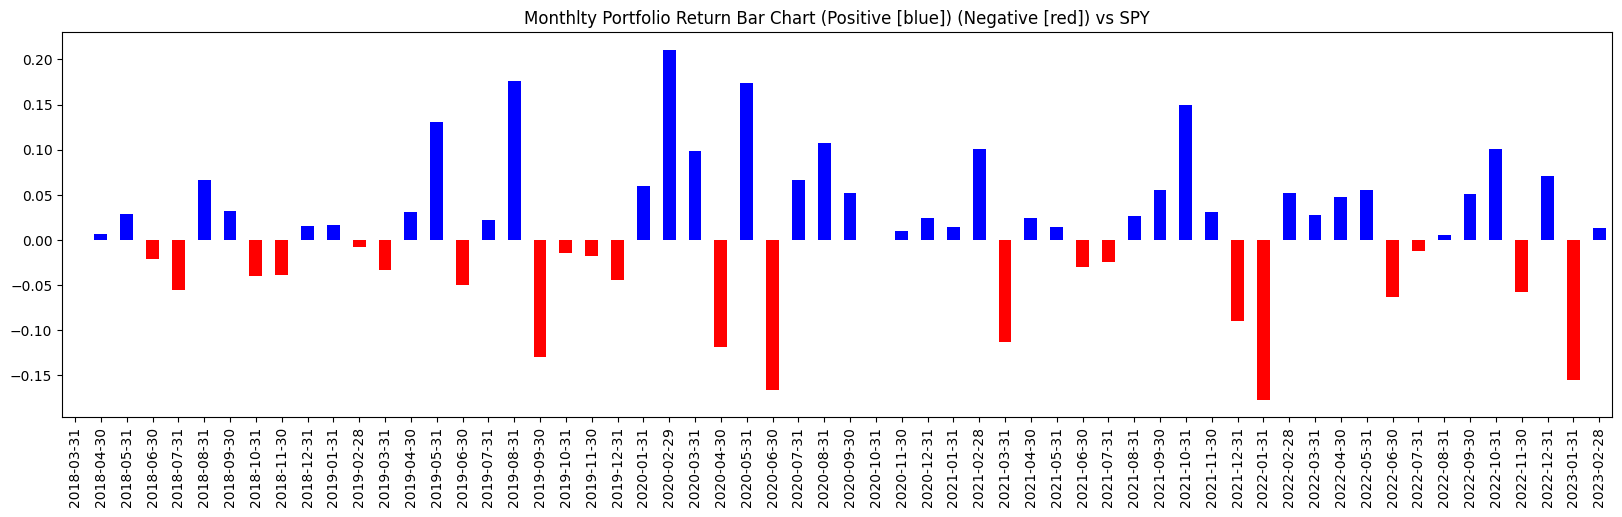

In [68]:
allTablePlot1 = plt.subplots(figsize = (20,5))
allTablePlot1 = allTable[0].plot(kind = 'bar',color = allTable['Positive?'].map({True: 'b', False: 'r' }))
plt.title('Monthlty Portfolio Return Bar Chart (Positive [blue]) (Negative [red]) vs SPY')
plt.show()

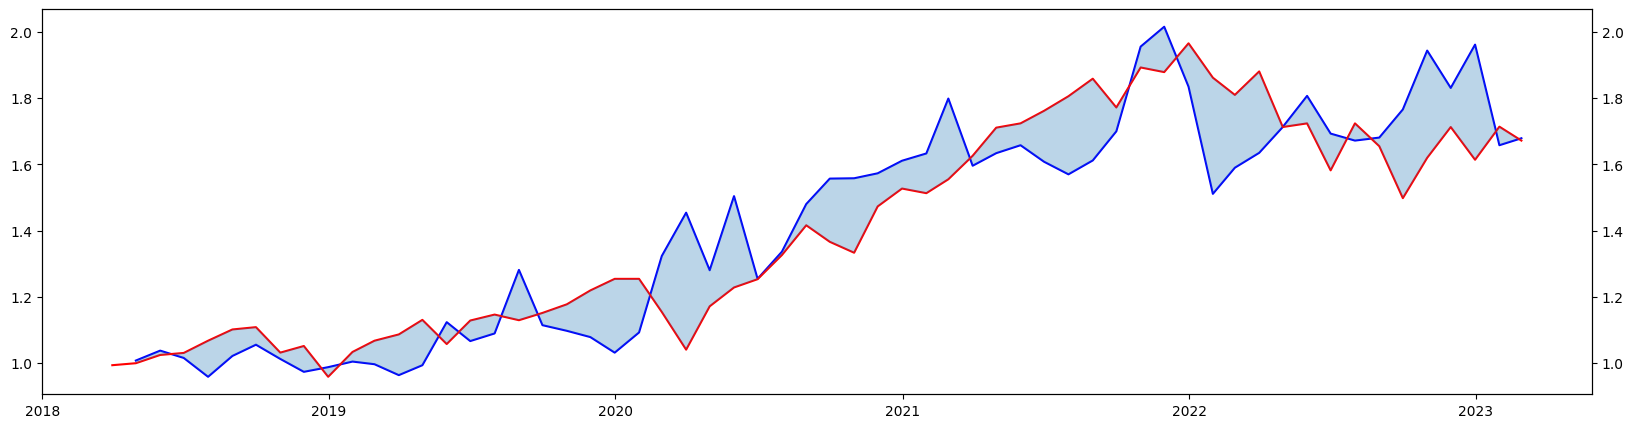

In [75]:
pt2, allTablePlot2 = plt.subplots(figsize = (20,5))
allf = allTablePlot2.twinx()
x = allTable.index
allf.fill_between(x ,allTable['Return(Cumulative)'], allTable['SPY(Cumulative)'],alpha = 0.30)
allTablePlot2.plot(x, allTable['Return(Cumulative)'], color = 'blue')
allTablePlot2.plot(x, allTable['SPY(Cumulative)'],color = 'red')
plt.show()